# Lab 10b: Computing the Sensitivity of American Option Contracts - `The Greeks`

The price of options contracts is sensitive to market conditions, e.g., the share price of the underlying asset, the number of days before the contract expires, the implied volatility, and other factors such as the value for the `risk-free rate` used in the risk-neutral pricing. The sensitivity of the options price can be characterized by sensitivity coefficients collectively called `The Greeks`:

* `Delta` measures the change in the option contract price with respect to a `1 USD` increase in the share price of the underlying asset
* `Gamma` measures the rate of change in an option’s `Delta` per a `1 USD`  change in the underlying stock’s share price.
* `Theta` measures how the price of an option contract decreases each day as the option nears expiration, with all other factors held constant. 
* `Vega` measures the rate of change in an option’s price per one-percentage-point change in the implied volatility of the underlying stock.
* `Rho` measures the expected change in an option’s price per a one-percentage-point change in interest rates, i.e., It tells you how much the price of an option should rise or fall if the risk-free interest rate increases or decreases.

### Learning objective
The objective of `Lab 10b` is to familiarize students with computing some common `Greeks`, namely `delta` and `theta` for American `call` and `put` contracts.

* __Task 1__: Build `Call` and `Put` contract models for `MU` options
* __Task 2__: Compute the premium of `52-DTE` options on `MU` using the CRR method
* __Task 3__: Compute `delta` for `52-DTE` `call` and `put` options contracts on `MU`
* __Task 4__: Compute `theta` for `52-DTE` `call` and `put` options contracts on `MU`

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

In [2]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/upstream/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Documents/GitHub/upstream/CHEME-5660-Labs-F23/Manifest.toml`


  Activating project at `~/Documents/GitHub/upstream/CHEME-5660-Labs-F23`


  No Changes to `~/Documents/GitHub/upstream/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Documents/GitHub/upstream/CHEME-5660-Labs-F23/Manifest.toml`


    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`


  No Changes to `~/Documents/GitHub/upstream/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Documents/GitHub/upstream/CHEME-5660-Labs-F23/Manifest.toml`


### Constants

In [3]:
Δt = (1/365);
DTE = 52*Δt;
r̄ = 0.0505; # 2-year T-bill
h = 520; # number of levels in the tree
θ = -1; # our data is for short contracts, need to correct the direction

## Data for a `52-DTE` `call` contract with `K = 70` for `MU`
<div>
    <center>
        <img src="figs/MU-Call-52-DTE.png" width="980"/>
    </center>
</div>

## Data for a `52-DTE` `put` contract with `K = 65` for `MU`
<div>
    <center>
        <img src="figs/MU-Put-52-DTE.png" width="980"/>
    </center>
</div>

## Task 1: Build `Call` and `Put` contract models for `MU` options
First, from the options chain snapshots shown above, fill in the `missing` values for various parameters that we will use to compute the price of the contract, and to compute `The Greeks`:

In [18]:
Sₒ = 67.30; # initial share price
IV_call = 0.3453;
IV_put = 0.3631;
premium_call = 2.58;
premium_put = 2.38;
K_call = 70.0
K_put = 65.0;

Use the `build(...)` method to construct an instances of the `MyAmericanPutContractModel` and `MyAmericanCallContractModel` models, which we'll use to model the contracts. 
* The `build(...)` method requires that we pass in values for the strike price `K`, a value for the `premium`, the sense (`sense = 1` for now, we'll correct for this in a bit) and `copy = 1`

In [19]:
put_contract_model = build(MyAmericanPutContractModel, (
            K = K_put, premium = premium_put, sense = 1, copy = 1
));

call_contract_model = build(MyAmericanCallContractModel, (
            K = K_call, premium = premium_call, sense = 1, copy = 1
));

## Task 2: Compute the price of `52-DTE` options on `MU`
Next, let's build instances of the `MyAdjacencyBasedCRREquityPriceTree` type for the `call` and `put` contracts, and populate the values in the tree using the `populate(...)` method. See the `L10a contract pricing` example for help with the parameters and syntax

In [20]:
treemodel_call = build(MyAdjacencyBasedCRREquityPriceTree, 
    (μ = r̄, T = DTE, σ = IV_call)) |> (x-> populate(x, Sₒ = Sₒ, h = h));

treemodel_put = build(MyAdjacencyBasedCRREquityPriceTree, 
    (μ = r̄, T = DTE, σ = IV_put)) |> (x-> populate(x, Sₒ = Sₒ, h = h));

Finally, we can compute the premium for the `put` and `call` contracts by passing the `treemodel_put` and `treemodel_call` instances (which holds the risk-neutral simulation of the share price) and contract model instances to the `premium(...)` function.

* Store the premium for the `call` contract in the `premium_call` variable, and the premium for the `put` contract in the `premium_put` variable 

In [21]:
premium_call = premium(call_contract_model, treemodel_call)

2.5636879100484906

In [22]:
premium_put = premium(put_contract_model, treemodel_put)

2.407174820886766

## Task 3: Compute the `delta` for `MU` option contract
We can compute a value for `delta` using the `delta(...)` function:

```julia
function delta(contract::Y; h::Int64=2, T::Float64=(1 / 365), 
        σ::Float64=0.15, Sₒ::Float64=1.0, μ::Float64=0.0015, 
        choice::Function=_rational) -> Float64 where {Y<:AbstractContractModel}
```

Compute `delta` values for the `call` and `put` contracts using the `delta(...)` function:

In [23]:
delta_call = θ*delta(call_contract_model, h = h, T = DTE, σ = IV_call, Sₒ = Sₒ, μ = r̄)

-0.4488676578232904

In [24]:
delta_put = θ*delta(put_contract_model, h = h, T = DTE, σ = IV_put, Sₒ = Sₒ, μ = r̄)

0.33814516448109444

## Task 4: Compute the `theta` for `MU` option contract

We can compute a value for `theta` using the `theta(...)` function:

```julia
function theta(contract::Y; h::Int64=2, T::Float64=(1 / 365), 
        σ::Float64=0.15, Sₒ::Float64=1.0, μ::Float64=0.0015, 
        choice::Function=_rational) -> Float64 where {Y<:AbstractContractModel}
```

Compute `theta` values for the `call` and `put` contracts using the `theta(...)` function:

In [11]:
theta_call = θ*theta(call_contract_model, h = h, T = DTE, σ = IV_call, Sₒ = Sₒ, μ = r̄)

0.03684985592234513

In [12]:
theta_put = θ*theta(put_contract_model, h = h, T = DTE, σ = IV_put, Sₒ = Sₒ, μ = r̄)

0.030375059453599196

## Recall: `AMD` options chain from last discussion

How do the `The Greeks` change for different strike values and sense (short vs. long)?

In [71]:
AMD_DTE = 31*Δt;
AMD_Sₒ = 117.50; # initial share price
options_dataset = MyOptionsChainDataSet();

In [43]:
# instantiate data structures for storing delta and theta values -
delta_call_AMD = []
theta_call_AMD = []
premium_call_AMD = []
delta_put_AMD = []
theta_put_AMD = []
premium_put_AMD = []

# loop through the options dataset and compute delta and theta for each contract -
for i in 1:nrow(options_dataset)
    if options_dataset[i, :Type] == "Call"

        # repeat the same process as above; build the contract model, build the tree model, compute premium
        call_contract_model = build(MyAmericanCallContractModel, (
            K = options_dataset[i, :Strike], premium = options_dataset[i, :Midpoint],
            sense = 1, copy = 1));
        treemodel_call = build(MyAdjacencyBasedCRREquityPriceTree, 
            (μ = r̄, T = AMD_DTE, σ = options_dataset[i, :IV])) |> (x-> populate(x, Sₒ = AMD_Sₒ, h = h));
        premium_call = premium(call_contract_model, treemodel_call);

        # compute delta and theta for the call contract -
        delta_call = θ*delta(call_contract_model, h = h, T = AMD_DTE, σ = options_dataset[i, :IV],
                            Sₒ = AMD_Sₒ, μ = r̄)
        theta_call = θ*theta(call_contract_model, h = h, T = AMD_DTE, σ = options_dataset[i, :IV],
                            Sₒ = AMD_Sₒ, μ = r̄)

        # store computed values; these are indexed by strike price
        push!(delta_call_AMD, delta_call)
        push!(theta_call_AMD, theta_call)
        push!(premium_call_AMD, premium_call)
    else
        # repeat the same process as above; build the contract model, build the tree model, compute premium
        put_contract_model = build(MyAmericanPutContractModel, (
            K = options_dataset[i, :Strike], premium = options_dataset[i, :Midpoint],
            sense = 1, copy = 1));
        treemodel_put = build(MyAdjacencyBasedCRREquityPriceTree, 
            (μ = r̄, T = AMD_DTE, σ = options_dataset[i, :IV])) |> (x-> populate(x, Sₒ = AMD_Sₒ, h = h));
        premium_put = premium(put_contract_model, treemodel_put);

        # compute delta and theta for the put contract -
        delta_put = θ*delta(put_contract_model, h = h, T = AMD_DTE, σ = options_dataset[i, :IV],
                            Sₒ = AMD_Sₒ, μ = r̄)
        theta_put = θ*theta(put_contract_model, h = h, T = AMD_DTE, σ = options_dataset[i, :IV],
                            Sₒ = AMD_Sₒ, μ = r̄)

        # store computed values; these are indexed by strike price
        push!(delta_put_AMD, delta_put)
        push!(theta_put_AMD, theta_put)
        push!(premium_put_AMD, premium_put)
    end
end

# create dataframes for storing the computed values -
call_df = DataFrame(Strike = options_dataset[1:length(delta_call_AMD), :Strike], Delta = delta_call_AMD,
                    Theta = theta_call_AMD, Premium = premium_call_AMD);
put_df = DataFrame(Strike = options_dataset[1:length(delta_put_AMD), :Strike], Delta = delta_put_AMD,
                    Theta = theta_put_AMD, Premium = premium_put_AMD);

Row,Strike,Delta,Theta,Premium
,Int64,Any,Any,Any
1,35,8.97555e-17,1.57445e-16,2.22647e-16
2,40,1.22396e-13,2.00584e-13,3.28485e-13
3,45,3.37852e-11,5.37936e-11,1.02032e-10
4,50,3.00278e-9,4.50998e-9,1.00629e-8
5,55,0.00133935,0.00208098,0.0123575
6,60,0.00309631,0.00471781,0.0357983
7,65,0.00386566,0.00499913,0.0361537
8,70,0.00552815,0.00640478,0.0480647
9,75,0.0100032,0.0104686,0.0941714


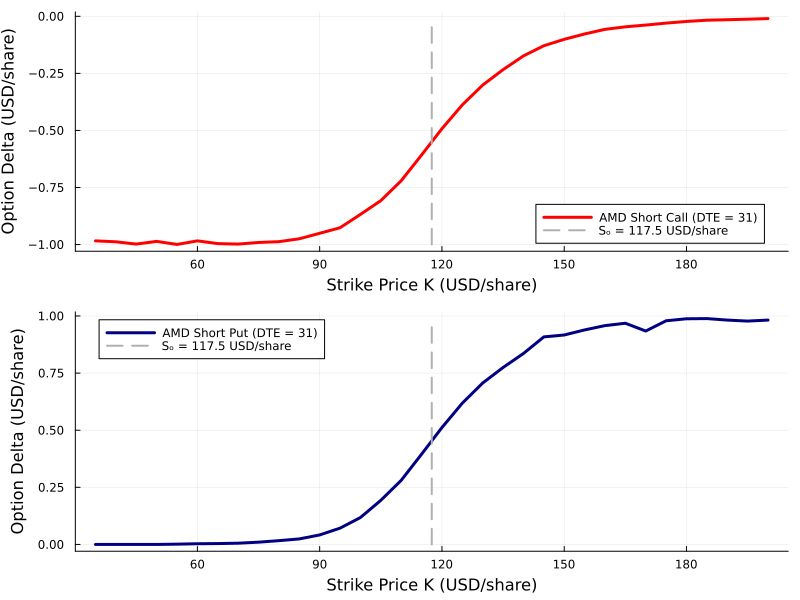

In [61]:
# plot the AMD short call delta values -
short_delta_call_plot = plot(call_df[:,:Strike], call_df[:,:Delta],label="AMD Short Call (DTE = 31)",
                        lw=3, c=:red, legend=:bottomright)

number_of_steps = 1001;
VLINE = zeros(number_of_steps, 2)
VLINE[:,1] .= AMD_Sₒ*ones(number_of_steps)
VLINE[:,2] .= range(minimum(call_df[:,:Delta]), stop = maximum(call_df[:,:Delta]), length = number_of_steps) |> collect;
plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(AMD_Sₒ) USD/share")
xlabel!("Strike Price K (USD/share)", fontsize=18)
ylabel!("Option Delta (USD/share)", fontsize=18)

# plot the AMD short put delta values -
short_delta_put_plot = plot(put_df[:,:Strike], put_df[:,:Delta],label="AMD Short Put (DTE = 31)",
                        lw=3, c=:navyblue)
                        VLINE[:,2] .= range(minimum(put_df[:,:Delta]), stop = maximum(put_df[:,:Delta]), length = number_of_steps) |> collect;
plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(AMD_Sₒ) USD/share")
xlabel!("Strike Price K (USD/share)", fontsize=18)
ylabel!("Option Delta (USD/share)", fontsize=18)

plot(short_delta_call_plot, short_delta_put_plot, layout=(2,1), size=(800, 600))

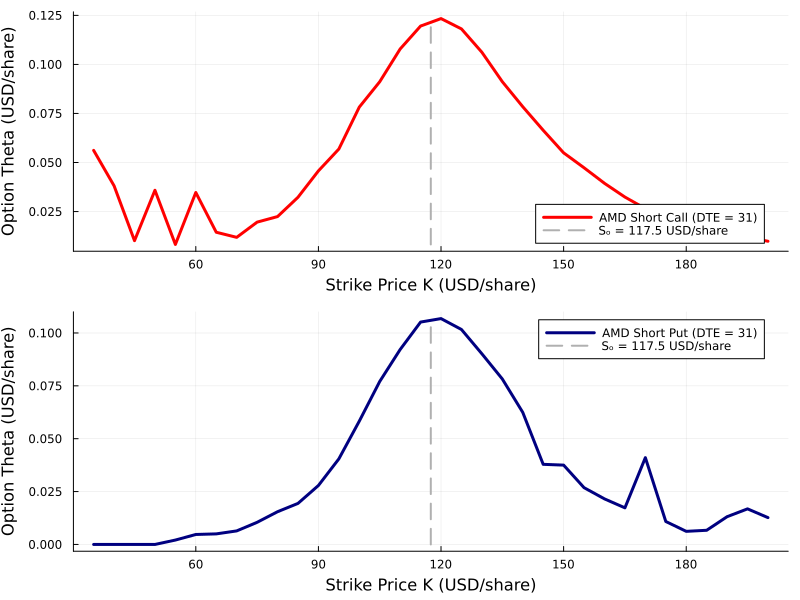

In [63]:
# plot the AMD short call theta values -
short_theta_call_plot = plot(call_df[:,:Strike], call_df[:,:Theta],label="AMD Short Call (DTE = 31)",
                        lw=3, c=:red, legend=:bottomright)
VLINE[:,2] .= range(minimum(call_df[:,:Theta]), stop = maximum(call_df[:,:Theta]), length = number_of_steps) |> collect;
plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(AMD_Sₒ) USD/share")
xlabel!("Strike Price K (USD/share)", fontsize=18)
ylabel!("Option Theta (USD/share)", fontsize=18)

# plot the AMD short put theta values -
short_theta_put_plot = plot(put_df[:,:Strike], put_df[:,:Theta],label="AMD Short Put (DTE = 31)",
                        lw=3, c=:navyblue)
VLINE[:,2] .= range(minimum(put_df[:,:Theta]), stop = maximum(put_df[:,:Theta]), length = number_of_steps) |> collect;
plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(AMD_Sₒ) USD/share")
xlabel!("Strike Price K (USD/share)", fontsize=18)
ylabel!("Option Theta (USD/share)", fontsize=18)

plot(short_theta_call_plot, short_theta_put_plot, layout=(2,1), size=(800, 600))

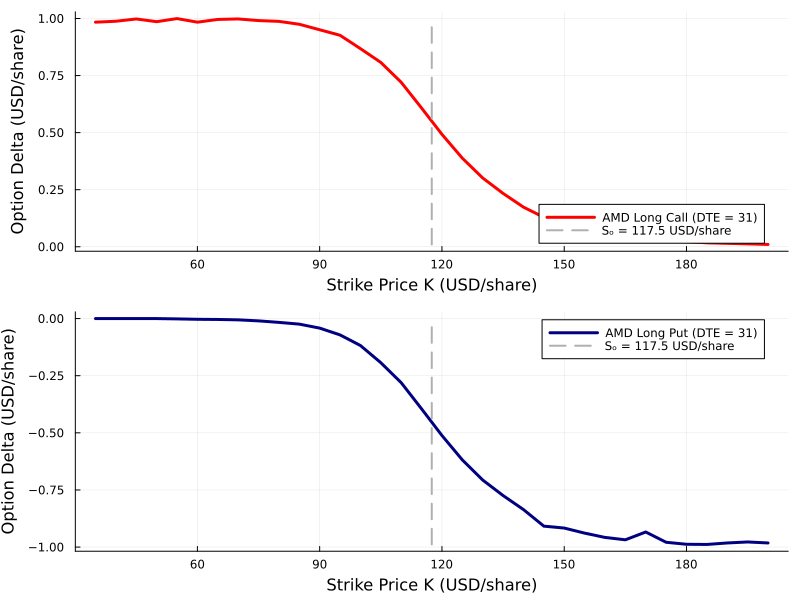

In [68]:
# plot the AMD long call delta values -
long_call_deltas = -1 .* call_df[:,:Delta]
long_delta_call_plot = plot(call_df[:,:Strike], long_call_deltas,label="AMD Long Call (DTE = 31)",
                        lw=3, c=:red, legend=:bottomright)
VLINE[:,2] .= range(minimum(long_call_deltas), stop = maximum(long_call_deltas), length = number_of_steps) |> collect;
plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(AMD_Sₒ) USD/share")
xlabel!("Strike Price K (USD/share)", fontsize=18)
ylabel!("Option Delta (USD/share)", fontsize=18)

# plot the AMD long put delta values -
long_put_deltas = -1 .* put_df[:,:Delta]
long_delta_put_plot = plot(put_df[:,:Strike], long_put_deltas,label="AMD Long Put (DTE = 31)",
                        lw=3, c=:navyblue)
VLINE[:,2] .= range(minimum(long_put_deltas), stop = maximum(long_put_deltas), length = number_of_steps) |> collect;
plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(AMD_Sₒ) USD/share")
xlabel!("Strike Price K (USD/share)", fontsize=18)
ylabel!("Option Delta (USD/share)", fontsize=18)

plot(long_delta_call_plot, long_delta_put_plot, layout=(2,1), size=(800, 600))

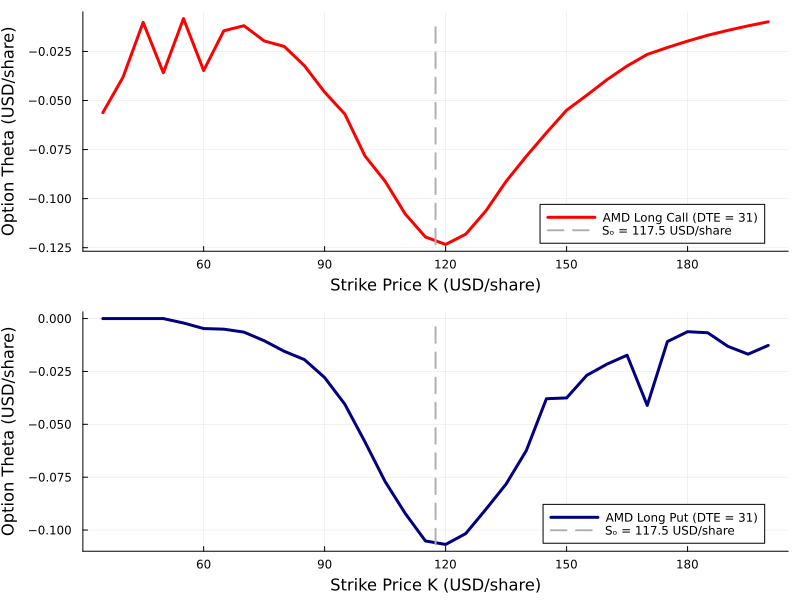

In [69]:
# plot the AMD long call theta values -
long_call_thetas = -1 .* call_df[:,:Theta]
long_theta_call_plot = plot(call_df[:,:Strike], long_call_thetas,label="AMD Long Call (DTE = 31)",
                        lw=3, c=:red, legend=:bottomright)
VLINE[:,2] .= range(minimum(long_call_thetas), stop = maximum(long_call_thetas), length = number_of_steps) |> collect;
plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(AMD_Sₒ) USD/share")
xlabel!("Strike Price K (USD/share)", fontsize=18)
ylabel!("Option Theta (USD/share)", fontsize=18)

# plot the AMD long put theta values -
long_put_thetas = -1 .* put_df[:,:Theta]
long_theta_put_plot = plot(put_df[:,:Strike], long_put_thetas,label="AMD Long Put (DTE = 31)",
                        lw=3, c=:navyblue)
VLINE[:,2] .= range(minimum(long_put_thetas), stop = maximum(long_put_thetas), length = number_of_steps) |> collect;
plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(AMD_Sₒ) USD/share")
xlabel!("Strike Price K (USD/share)", fontsize=18)
ylabel!("Option Theta (USD/share)", fontsize=18)

plot(long_theta_call_plot, long_theta_put_plot, layout=(2,1), size=(800, 600))